In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint



### Read data

In [71]:
# Loda data
target = pd.read_csv('../data/processed/properties.csv')
features = pd.read_csv('../data/processed/features.csv')

# features = features[['Period', 'TPU', 'GPR', 'CORESA', 'CPTOTSAXN', 'DPANUSSPB', 'DXGSRMRCHSACD','DMGSRMRCHSACD', 'IPTOTSAKD', 'IMPCOV', 'NEER', 'REER', 'RETSALESSA', 'TOTRESV', 'UNEMPSA_']]   IMPCOV

features = features[['Period', 'TPU', 'GPR', 'CPTOTSAXN', 'DPANUSSPB', 'DXGSRMRCHSACD','DMGSRMRCHSACD', 'IPTOTSAKD', 'IMPCOV', 'NEER', 'REER', 'RETSALESSA', 'TOTRESV', 'UNEMPSA_','GEPU']]

# Merge data
df = pd.merge(target, features, on='Period')

# Convert Period column to datetime
df['Period'] = pd.to_datetime(df['Period'])


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Period         164 non-null    datetime64[ns]
 1   num_nodes      164 non-null    int64         
 2   num_edges      164 non-null    int64         
 3   density        164 non-null    float64       
 4   clustering     164 non-null    float64       
 5   assortativity  164 non-null    float64       
 6   shortest_path  163 non-null    float64       
 7   TPU            164 non-null    float64       
 8   GPR            164 non-null    float64       
 9   CPTOTSAXN      164 non-null    float64       
 10  DPANUSSPB      145 non-null    float64       
 11  DXGSRMRCHSACD  164 non-null    float64       
 12  DMGSRMRCHSACD  164 non-null    float64       
 13  IPTOTSAKD      164 non-null    float64       
 14  IMPCOV         164 non-null    float64       
 15  NEER           164 non-

In [73]:
# Exclude 'Period'
numerical_columns = df.columns.difference(['Period'])  # Exclude 'Period'

# Create a StandardScaler
scaler = StandardScaler()  

# Standardize the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Use the interpolate method to fill missing values with interpolation
df = df.interpolate()

# Sort the DataFrame by the 'period' column
df = df.sort_values(by='Period')


In [74]:
df.head()

,Period,num_nodes,num_edges,density,clustering,assortativity,shortest_path,TPU,GPR,CPTOTSAXN,...,DXGSRMRCHSACD,DMGSRMRCHSACD,IPTOTSAKD,IMPCOV,NEER,REER,RETSALESSA,TOTRESV,UNEMPSA_,GEPU
0,2010-01-01,-1.907728,-2.123956,-0.662045,-1.736416,0.897781,1.708130,-0.704058,-0.197764,-1.426643,...,-1.629180,-1.734612,-1.962292,-0.116903,-0.682534,-0.874579,0.406478,-2.744138,1.333355,-1.032877
1,2010-02-01,-0.812829,-2.025574,-1.541808,0.673488,-0.766521,0.961073,-0.811993,-0.573908,-1.417138,...,-1.564621,-1.603232,-1.937374,-0.421366,-0.457849,-0.730151,0.432561,-2.735926,1.253469,-1.056117
2,2010-03-01,-1.086554,-1.189334,-0.333355,1.536279,-0.633031,-0.242651,-0.626296,-0.802887,-1.407470,...,-1.466508,-1.690665,-1.831265,-0.112547,-0.553656,-0.882001,0.601025,-2.671689,1.228940,-1.108914
3,2010-04-01,-1.360279,-1.907517,-0.913957,-1.713061,-0.709437,1.308652,-0.684992,-0.295457,-1.395858,...,-1.446469,-1.709756,-1.776203,0.113687,-0.607243,-0.954863,-0.507697,-2.556674,1.257918,-1.160644
4,2010-05-01,-2.181453,-1.651725,0.169031,1.351597,-0.365774,-0.639831,-0.762968,-0.288626,-1.387176,...,-1.517224,-1.806146,-1.716878,0.301746,-0.181691,-0.594848,-0.430295,-2.594208,1.132896,-0.563886


### Uncertainty measurement

In [75]:
import pandas as pd

# Get the actual names of the target columns
target_columns = ['num_nodes', 'num_edges', 'density', 'clustering', 'assortativity', 'shortest_path']

# Copy the original DataFrame to avoid modifying the original data
lag1_df = df.copy()
lag2_df = df.copy()
lag3_df = df.copy()

# Shift target columns by 1, 3, and 6 periods in respective lag DataFrames
for column in target_columns:
    lag1_df[f'{column}'] = lag1_df[column].shift(1)
    lag2_df[f'{column}'] = lag2_df[column].shift(2)
    lag3_df[f'{column}'] = lag3_df[column].shift(3)

# Shift the Period column
lag1_df['Period'] = lag1_df['Period'] - pd.DateOffset(months=1)
lag2_df['Period'] = lag2_df['Period'] - pd.DateOffset(months=2)
lag3_df['Period'] = lag3_df['Period'] - pd.DateOffset(months=3)

# Drop rows with NaN values in lag DataFrames
lag1_df = lag1_df.dropna()
lag2_df = lag2_df.dropna()
lag3_df = lag3_df.dropna()


In [76]:
lag3_df

,Period,num_nodes,num_edges,density,clustering,assortativity,shortest_path,TPU,GPR,CPTOTSAXN,...,DXGSRMRCHSACD,DMGSRMRCHSACD,IPTOTSAKD,IMPCOV,NEER,REER,RETSALESSA,TOTRESV,UNEMPSA_,GEPU
3,2010-01-01,-1.907728,-2.123956,-0.662045,-1.736416,0.897781,1.708130,-0.684992,-0.295457,-1.395858,...,-1.446469,-1.709756,-1.776203,0.113687,-0.607243,-0.954863,-0.507697,-2.556674,1.257918,-1.160644
4,2010-02-01,-0.812829,-2.025574,-1.541808,0.673488,-0.766521,0.961073,-0.762968,-0.288626,-1.387176,...,-1.517224,-1.806146,-1.716878,0.301746,-0.181691,-0.594848,-0.430295,-2.594208,1.132896,-0.563886
5,2010-03-01,-1.086554,-1.189334,-0.333355,1.536279,-0.633031,-0.242651,-0.648748,-0.028929,-1.380546,...,-1.397324,-1.677439,-1.719766,0.033732,0.019529,-0.420047,-0.334323,-2.556138,1.037405,-0.741009
6,2010-04-01,-1.360279,-1.907517,-0.913957,-1.713061,-0.709437,1.308652,-0.623662,-0.620476,-1.366895,...,-1.357918,-1.592783,-1.692744,0.124748,-0.196988,-0.571097,-0.017825,-2.360319,1.002800,-0.632830
7,2010-05-01,-2.181453,-1.651725,0.169031,1.351597,-0.365774,-0.639831,-0.602719,-0.564604,-1.351865,...,-1.291262,-1.576119,-1.656546,0.121644,-0.302384,-0.643085,-0.026127,-2.335409,0.961246,-0.921952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2023-01-01,-1.907728,0.050270,1.939393,1.503772,-1.010981,-3.040825,-0.524230,0.330380,2.442303,...,1.705781,1.652313,1.521959,-1.463461,1.289483,1.267040,0.373407,1.135055,-2.074834,0.609680
160,2023-02-01,1.103245,0.532339,-0.433821,-0.656225,-1.214926,0.114799,-0.031503,0.387578,2.490868,...,1.822582,1.772558,1.624408,-1.700074,1.461327,1.481361,0.440829,1.037951,-2.085408,0.563506
161,2023-03-01,1.376969,1.653885,0.493051,0.416650,-1.039449,-1.301886,-0.171607,0.460178,2.552205,...,1.650456,1.744182,1.667872,-1.629963,1.466470,1.426521,0.424683,1.077523,-2.190726,0.582547
162,2023-04-01,0.282070,0.158490,-0.091462,0.440093,-1.267160,-1.014949,0.038107,0.345565,2.668025,...,1.603611,1.494509,1.644231,-1.254175,1.183770,1.061321,0.392201,1.140946,-2.121485,0.535618


In [77]:
# ['TPU', 'GPR', 'CORESA', 'CPTOTSAXN', 'DPANUSSPB', 'DXGSRMRCHSACD','DMGSRMRCHSACD', 'IPTOTSAKD', 'IMPCOV', 'NEER', 'REER', 'RETSALESSA', 'TOTRESV', 'UNEMPSA_', 'GEPU']
#features = df.columns[[7,8,9,10,11,14,15,16,17,18,20,21]]
#features

In [78]:
# Function
def perform_random_search_cv(X_train, y_train, random_state=42):
    param_dist = {
        'n_estimators': randint(10, 100),
        'max_depth': [None] + list(np.arange(3, 20)),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Ensure the RandomForestRegressor has a random_state set for reproducibility
    rf_model = RandomForestRegressor(random_state=random_state)
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Set the random_state in RandomizedSearchCV for reproducibility
    random_search = RandomizedSearchCV(
        rf_model, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=random_state
    )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    return random_search.best_estimator_

def calculate_mse_per_period(df, target_column):
    features = df.columns[7:]  # Exclude 'period' and targets columns
    target = target_column

    # Split the dataset into train and test sets based on time
    train_size = int(len(df) * 0.8)
    train_set, test_set = df[:train_size], df[train_size:]

    # Perform cross-validation and random search for hyperparameter tuning on the training set
    best_model = perform_random_search_cv(train_set[features], train_set[target])

    # Evaluate the best model on the test set
    test_predictions = best_model.predict(test_set[features])
    overall_test_mse = mean_squared_error(test_set[target], test_predictions)
    print(f'Overall Test Set Mean Squared Error for {target_column}: {overall_test_mse}')

    # Use the best model to predict on the entire dataset
    full_dataset_predictions = best_model.predict(df[features])

    # Add the predicted values to the DataFrame
    df[f'predicted_{target_column}'] = full_dataset_predictions

    # Calculate MSE for each period
    mse_per_period = df.groupby('Period').apply(lambda group: mean_squared_error(group[target], group[f'predicted_{target_column}'])).reset_index()
    mse_per_period.columns = ['Period', f'mse_{df}']
    return mse_per_period

In [79]:
# List of columns to iterate through
columns_to_calculate_mse = ['num_nodes', 'num_edges', 'density', 'clustering', 'assortativity', 'shortest_path']

# Dictionary to store the calculated MSE DataFrames for each column
mse_per_column_dict = {}

# Assuming lag1_df, lag3_df, lag6_df are your lag DataFrames
for column in columns_to_calculate_mse:
    lag1_mse = calculate_mse_per_period(lag1_df, target_column=column)
    lag2_mse = calculate_mse_per_period(lag2_df, target_column=column)
    lag3_mse = calculate_mse_per_period(lag3_df, target_column=column)

    # Merge the MSE DataFrames on the 'period' column
    merged_mse_df = lag1_mse.merge(lag2_mse, on='Period').merge(lag3_mse, on='Period')

    # Rename the columns to include the column name and lag
    merged_mse_df.columns = ['Period', f'mse_lag1_{column}', f'mse_lag2_{column}', f'mse_lag3_{column}']

    # Store the MSE DataFrame for the current column in the dictionary
    mse_per_column_dict[column] = merged_mse_df

# Create separate DataFrames for each lag
lag1_mse = pd.concat([mse_df[f'mse_lag1_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag2_mse = pd.concat([mse_df[f'mse_lag2_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag3_mse = pd.concat([mse_df[f'mse_lag3_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)

# Include the 'period' column in the resulting DataFrames
lag1_mse.insert(0, 'Period', mse_per_column_dict[columns_to_calculate_mse[0]]['Period'])
lag2_mse.insert(0, 'Period', mse_per_column_dict[columns_to_calculate_mse[0]]['Period'])
lag3_mse.insert(0, 'Period', mse_per_column_dict[columns_to_calculate_mse[0]]['Period'])

Best Parameters: {'bootstrap': True, 'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 71}
Overall Test Set Mean Squared Error for num_nodes: 0.8426922007367628
Best Parameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 87}
Overall Test Set Mean Squared Error for num_nodes: 0.8980024066741636
Best Parameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 87}
Overall Test Set Mean Squared Error for num_nodes: 1.0736548649449313
Best Parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 48}
Overall Test Set Mean Squared Error for num_edges: 0.29617819742211715
Best Parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 48}
Overall Test Set Mean Squared Error for num_edges: 0.3743487726108578
Best Parameters: {'bootstrap': True, 'max_dept

In [80]:
lag1_mse.head()

,Period,mse_lag1_num_nodes,mse_lag1_num_edges,mse_lag1_density,mse_lag1_clustering,mse_lag1_assortativity,mse_lag1_shortest_path
0,2010-01-01,0.727651,0.009343,0.023102,1.355422,1.333437,0.159844
1,2010-02-01,0.062619,0.006866,0.096702,0.527170,0.016641,0.213016
2,2010-03-01,0.000833,0.073470,0.076178,1.329008,0.020227,0.024917
3,2010-04-01,0.048719,0.000022,0.002782,0.888309,0.063508,0.014446
4,2010-05-01,0.678025,0.000764,0.251749,0.981629,0.006163,0.235331


In [81]:
lag2_mse.head()

,Period,mse_lag2_num_nodes,mse_lag2_num_edges,mse_lag2_density,mse_lag2_clustering,mse_lag2_assortativity,mse_lag2_shortest_path
0,2010-01-01,0.456286,0.009050,0.016853,0.970437,0.958396,3.418722e-02
1,2010-02-01,0.105339,0.002102,0.117260,0.771959,0.082278,3.765487e-02
2,2010-03-01,0.024441,0.065849,0.052064,0.247207,0.009603,2.333149e-03
3,2010-04-01,0.013444,0.003492,0.001562,0.320805,0.021130,4.455271e-07
4,2010-05-01,0.733685,0.000738,0.173435,1.462911,0.088436,1.448569e-01


In [82]:
lag3_mse.head()

,Period,mse_lag3_num_nodes,mse_lag3_num_edges,mse_lag3_density,mse_lag3_clustering,mse_lag3_assortativity,mse_lag3_shortest_path
0,2010-01-01,0.481869,0.012409,0.001376,0.241853,0.847826,0.016066
1,2010-02-01,0.124892,0.009821,0.164293,0.260388,0.006810,0.100920
2,2010-03-01,0.018423,0.051853,0.010567,0.399012,0.013895,0.001633
3,2010-04-01,0.005273,0.009056,0.032757,0.362123,0.183478,0.003884
4,2010-05-01,0.730869,0.003317,0.186444,0.957106,0.109276,0.556659


In [83]:

def calculate_uncertainty_metrics(mse_df):
    # Calculate 'uncertainty' as the average of the columns (excluding 'Period')
    mse_df['uncertainty'] = mse_df.iloc[:, 1:].mean(axis=1)
    
    # Keep only the 'Period' and 'uncertainty' columns
    uncertainties = mse_df[['Period', 'uncertainty']]
    
    return uncertainties


In [84]:

# Calculate 'avg_uncertainty' and 'weighted_uncertainty' for each row in mse_df
uncertainties_1 = calculate_uncertainty_metrics(lag1_mse)
uncertainties_2 = calculate_uncertainty_metrics(lag2_mse)
uncertainties_3 = calculate_uncertainty_metrics(lag3_mse)



In [85]:
uncertainties_1

,Period,uncertainty
0,2010-01-01,0.601467
1,2010-02-01,0.153836
2,2010-03-01,0.254106
3,2010-04-01,0.169631
4,2010-05-01,0.358944
...,...,...
156,2023-01-01,3.734089
157,2023-02-01,1.108370
158,2023-03-01,1.139219
159,2023-04-01,1.162030


In [86]:
# # Convert Period column to datetime
# uncertainties_1['Period'] = pd.to_datetime(uncertainties_1['Period'])
# uncertainties_2['Period'] = pd.to_datetime(uncertainties_2['Period'])
# uncertainties_4['Period'] = pd.to_datetime(uncertainties_4['Period'])

# # Shift the Period column
# uncertainties_1['Period'] = uncertainties_1['Period'] - pd.DateOffset(months=1)
# uncertainties_2['Period'] = uncertainties_2['Period'] - pd.DateOffset(months=2)
# uncertainties_4['Period'] = uncertainties_4['Period'] - pd.DateOffset(months=4)


In [87]:
uncertainties_1


,Period,uncertainty
0,2010-01-01,0.601467
1,2010-02-01,0.153836
2,2010-03-01,0.254106
3,2010-04-01,0.169631
4,2010-05-01,0.358944
...,...,...
156,2023-01-01,3.734089
157,2023-02-01,1.108370
158,2023-03-01,1.139219
159,2023-04-01,1.162030


In [88]:
uncertainties_2

,Period,uncertainty
0,2010-01-01,0.407535
1,2010-02-01,0.186099
2,2010-03-01,0.066916
3,2010-04-01,0.060072
4,2010-05-01,0.434010
...,...,...
156,2023-01-01,4.536946
157,2023-02-01,1.405718
158,2023-03-01,1.368388
159,2023-04-01,1.932325


In [89]:
uncertainties_3

,Period,uncertainty
0,2010-01-01,0.266900
1,2010-02-01,0.111188
2,2010-03-01,0.082563
3,2010-04-01,0.099428
4,2010-05-01,0.423945
...,...,...
156,2023-01-01,5.033214
157,2023-02-01,0.934340
158,2023-03-01,1.364329
159,2023-04-01,1.458204


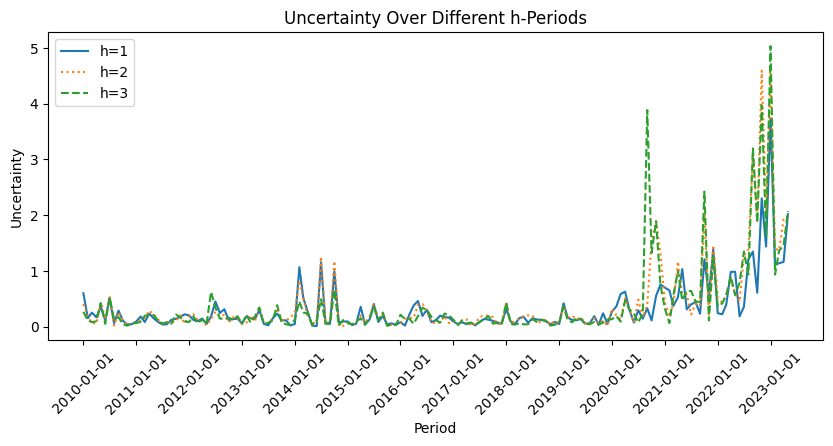

In [90]:
# Plot 'avg_uncertainty'
plt.figure(figsize=(10, 4))
plt.plot(uncertainties_1['Period'], uncertainties_1['uncertainty'], label='h=1', linestyle='-')
plt.plot(uncertainties_2['Period'], uncertainties_2['uncertainty'], label='h=2', linestyle=':')
plt.plot(uncertainties_3['Period'], uncertainties_3['uncertainty'], label='h=3', linestyle='--')


plt.title('Uncertainty Over Different h-Periods')
plt.xlabel('Period')
plt.ylabel('Uncertainty')
plt.legend()

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(uncertainties_1['Period'][::12], rotation=45)
plt.show()



In [91]:
# Save to csv
uncertainties_1.to_csv('../data/processed/uncertainty_index.csv', index=False, encoding='utf')